In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pcntoolkit.dataio.norm_data import NormData
from pcntoolkit.normative_model.norm_conf import NormConf
from pcntoolkit.normative_model.norm_factory import (
    create_normative_model,
    load_normative_model,
)
from pcntoolkit.regression_model.hbr.hbr import HBR
from pcntoolkit.regression_model.hbr.hbr_conf import HBRConf
from pcntoolkit.regression_model.hbr.param2 import make_param
from pcntoolkit.util.plotter import plot_centiles, plot_qq

plt.rcParams["figure.figsize"] = (5, 5)


In [8]:
data = pd.read_csv("resources/data/fcon1000.csv")
data["sex "] = np.where(data["sex"] == 1, ["male"], ["female"])
site_counts = data.groupby(["site", "sex"]).size().reset_index(name="counts")  # type: ignore
sex_count_per_site = site_counts["site"].value_counts()
sites_with_one_sex = sex_count_per_site[sex_count_per_site == 1]
sites_with_one_sex.index
data = data[~data["site"].isin(sites_with_one_sex.index)]
site_counts = site_counts[site_counts["counts"] < 10]
data = data[~data["site"].isin(site_counts["site"])]


covariates = ["age"]
batch_effects = ["sex", "site"]
response_vars = ["rh_MeanThickness_thickness", "WM-hypointensities"]
norm_data = NormData.from_dataframe(
    name="full",
    dataframe=data,
    covariates=covariates,
    batch_effects=batch_effects,
    response_vars=response_vars,
)

extend_sites = ["Milwaukee_b", "Oulu"]
extend_data, fit_data = norm_data.split_batch_effects(
    {"site": extend_sites}, names=("extend", "fit")
)


train, test = fit_data.train_test_split()
extend_train, extend_test = extend_data.train_test_split()

In [9]:
# Create a NormConf object
norm_conf = NormConf(
    savemodel=True,
    saveresults=True,
    save_dir="resources/hbr/save_dir",
    inscaler="standardize",
    outscaler="standardize",
    basis_function="bspline",
    basis_function_kwargs={"order": 3, "nknots": 5},
)

mu = make_param(
    name="mu",
    linear=True,
    slope=make_param(dist_name="Normal", dist_params=(0.0, 5.0)),
    intercept=make_param(
        random=True,
        sigma=make_param(dist_name="HalfNormal", dist_params=(1.0,)),
        mu=make_param(dist_name="Normal", dist_params=(0.0, 0.5)),
    ),
)
sigma = make_param(
    name="sigma",
    linear=True,
    slope=make_param(dist_name="Normal", dist_params=(0.0, 3.0)),
    intercept=make_param(
        dist_name="Normal",
        dist_params=(
            1.0,
            1.0,
        ),
    ),
    mapping="softplus",
    mapping_params=(0.0, 3.0),
)


# Configure the HBRConf object
hbr_conf = HBRConf(
    draws=1500,
    tune=500,
    chains=4,
    pymc_cores=16,
    likelihood="Normal",
    mu=mu,
    sigma=sigma,
    nuts_sampler="nutpie",
    init="jitter+adapt_diag",
)

# Using the factory method
norm_hbr = create_normative_model(norm_conf, hbr_conf)

Configuration of normative model is valid.


In [10]:
predictions = norm_hbr.fit_predict(train, test)

Going to fit and predict 2 models
Fitting and predicting model for rh_MeanThickness_thickness


<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> Cannot convert Type Tensor3(float64, shape=(?, ?, 1)) (of Variable Reshape{3}.0) into Type Matrix(float64, shape=(?, 1)). You can try to manually convert Reshape{3}.0 into a Matrix(float64, shape=(?, 1)). ravel_multidimensional_int_idx
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: ravel_multidimensional_int_idx
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSubtensor(ExpandDims{axis=0}.0, [[0]], Clip.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/opt/anaconda3/envs/param2/lib/python3.12/site-packages/pytensor/graph/rewriting/basic.py", line 1959, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/opt/anaconda3/envs/param2/lib/python3.12/site-packages/pytensor/graph/features.py", line 627, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason=

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,113,0.16,31
,2000,16,0.16,31
,2000,14,0.19,31
,2000,15,0.19,31


Sampling: [y_pred]


Output()

Fitting and predicting model for WM-hypointensities


<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> Cannot convert Type Tensor3(float64, shape=(?, ?, 1)) (of Variable Reshape{3}.0) into Type Matrix(float64, shape=(?, 1)). You can try to manually convert Reshape{3}.0 into a Matrix(float64, shape=(?, 1)). ravel_multidimensional_int_idx
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: ravel_multidimensional_int_idx
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSubtensor(ExpandDims{axis=0}.0, [[0]], Clip.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/opt/anaconda3/envs/param2/lib/python3.12/site-packages/pytensor/graph/rewriting/basic.py", line 1959, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/opt/anaconda3/envs/param2/lib/python3.12/site-packages/pytensor/graph/features.py", line 627, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason=

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,30,0.14,31
,2000,32,0.14,31
,2000,62,0.14,31
,2000,66,0.15,63


Sampling: [y_pred]


Output()

73116 Saving model to resources/hbr/save_dir


OSError: Unable to create file (unable to truncate a file which is already open)

In [5]:
norm_hbr = load_normative_model("resources/hbr/save_dir")
model: HBR = norm_hbr.regression_models.get("WM-hypointensities")  # type: ignore
extended_model = norm_hbr.extend(extend_train)


Configuration of normative model is valid.
Configuration of normative model is valid.


Sampling: [sex, site, y_pred]


Output()

Sampling: [y_pred]


Output()

Only 15 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


73116 - Going to fit 2 models

73116 - Fitting model for rh_MeanThickness_thickness



<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> Cannot convert Type Tensor3(float64, shape=(?, ?, 1)) (of Variable Reshape{3}.0) into Type Matrix(float64, shape=(?, 1)). You can try to manually convert Reshape{3}.0 into a Matrix(float64, shape=(?, 1)). ravel_multidimensional_int_idx
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: ravel_multidimensional_int_idx
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSubtensor(ExpandDims{axis=0}.0, [[0]], Clip.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/opt/anaconda3/envs/param2/lib/python3.12/site-packages/pytensor/graph/rewriting/basic.py", line 1959, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/opt/anaconda3/envs/param2/lib/python3.12/site-packages/pytensor/graph/features.py", line 627, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason=

Progress,Draws,Divergences,Step Size,Gradients/Draw
,20,14,3.74,1
,20,14,3.74,1
,20,13,1.60,1
,20,14,7.47,1


Only 15 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


73116 - Fitting model for WM-hypointensities



<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> Cannot convert Type Tensor3(float64, shape=(?, ?, 1)) (of Variable Reshape{3}.0) into Type Matrix(float64, shape=(?, 1)). You can try to manually convert Reshape{3}.0 into a Matrix(float64, shape=(?, 1)). ravel_multidimensional_int_idx
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: ravel_multidimensional_int_idx
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSubtensor(ExpandDims{axis=0}.0, [[0]], Clip.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/opt/anaconda3/envs/param2/lib/python3.12/site-packages/pytensor/graph/rewriting/basic.py", line 1959, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/opt/anaconda3/envs/param2/lib/python3.12/site-packages/pytensor/graph/features.py", line 627, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason=

Progress,Draws,Divergences,Step Size,Gradients/Draw
,20,14,1.87,1
,20,14,14.94,1
,20,14,3.74,1
,20,14,0.80,1


73116 Saving model to resources/hbr/save_dir_extend
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr/save_dir_extend/model


Sampling: [y_pred]


Output()

Going to predict 2 models
Predicting model for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Predicting model for WM-hypointensities


Sampling: [y_pred]


Output()

Computing zscores for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Computing zscores for WM-hypointensities


Sampling: [y_pred]


Output()

Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Computing centiles for WM-hypointensities


/opt/anaconda3/envs/param2/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:341: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))
Sampling: [y_pred]


Output()

Computing centiles for rh_MeanThickness_thickness


Computing centiles for WM-hypointensities


Sampling: [y_pred]


Output()

Sampling: [y_pred]


Output()

Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr/save_dir/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr/save_dir/plots
Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Computing centiles for WM-hypointensities


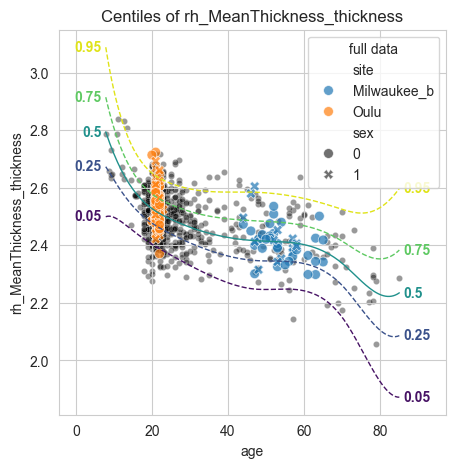

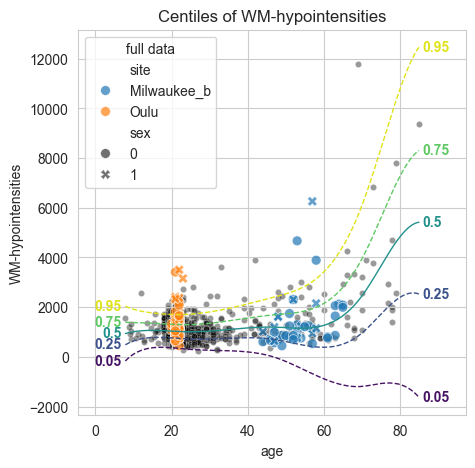

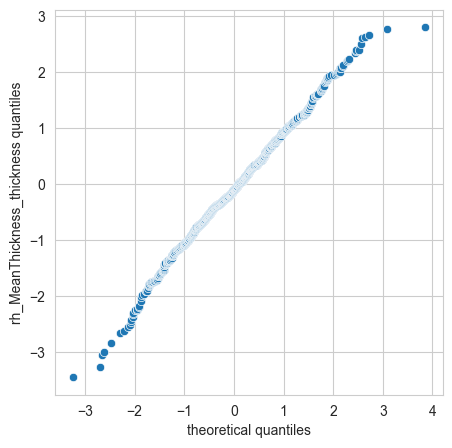

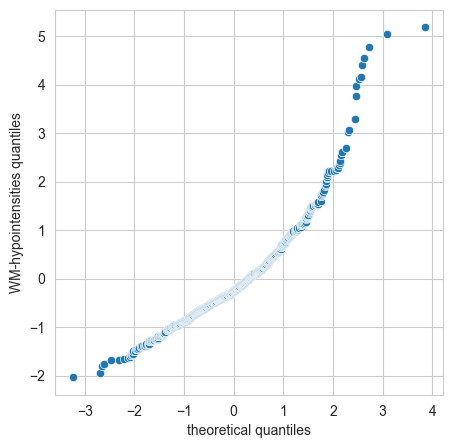

In [13]:
out = extended_model.predict(norm_data)
plot_centiles(
    extended_model,
    norm_data,
    covariate="age",
    show_data=True,
    batch_effects={"site": extend_sites},
)
plot_qq(norm_data)


We can save, load, predict, and plot just as before. 

If the orinal save directory path was `{path}/{save_dir}`, then the transfered model's save directory path will be `{path}/{save_dir}_tansfer`, and the same holds for the log dir path